In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline

In [84]:
class prediction_model:

	def __init__(self, model, filepath):

		self.model = model
		self.path = filepath

		self.data = self.translate_data(filepath)

		self.data, self.names = self.build_training(self.data)

		self.Train, self.Test = train_test_split(self.data, test_size=0.2, shuffle=False, random_state=0)
		
		self.calculate_technical_indicators()


######
####
##		Helper Functions to handle initiation of the model
#

###
##	Heloper function to ensure that the data is from nasdaq.com
#
	def ensure_nasdaq(self, df):
		##check headdings are correct:
		if 'Date' not in df.columns:
			raise ValueError("The data does not contain the Date column.")

		if 'Open' not in df.columns:
			raise ValueError("The data does not contain the Open column.")
		
		if 'Close/Last' not in df.columns:
			raise ValueError("The data does not contain the Close column.")
			
		if 'High' not in df.columns:
			raise ValueError("The data does not contain the High column.")
		
		if 'Low' not in df.columns:
			raise ValueError("The data does not contain the Low column.")

		if 'Volume' not in df.columns:
			raise ValueError("The data does not contain the Volume column.")
		
		print("Data is in the correct format and likely origins from nasdaq.com")

		return True
	

###
##	Helper function to translate the data to the correct format for analysis
#
	def translate_data(self, path):
		data = pd.read_csv(path)
		# Ensure that the data is from nasdaq.com
	
		if(not self.ensure_nasdaq(data)):
			raise ValueError("The data is not from nasdaq.com. Please provide data from nasdaq.com")
			return None


		# Translate the data and remove $ from the data and multiply close, open, high and low by a factor of 100 and convert them to integers
		data['Date'] = pd.to_datetime(data['Date'])
		data['Close/Last'] = data['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
		data['Open'] = data['Open'].replace('[\$,]', '', regex=True).astype(float)
		data['High'] = data['High'].replace('[\$,]', '', regex=True).astype(float)
		data['Low'] = data['Low'].replace('[\$,]', '', regex=True).astype(float)
		



		# inverse the entire dataframe
		data = data.iloc[::-1]

		# reset the index
		data = data.reset_index(drop=True)

		return data
	

###
##	Helper function to build the training data from the raw data
#
	def build_training(self, df):
		lags = 5
		names = []

		df['returns'] = np.log(df['Close/Last'].pct_change() + 1)


		for i in range(1, lags+1):
			df[f'lag_{i}'] = df['returns'].shift(i)

			names.append(f'lag_{i}')

		df.dropna(inplace=True)

		return df, names


#
##		End of Helper Functions
####
######

	
	def train_model(self):
		self.calculate_technical_indicators()

		self.X_train = self.Train[self.names]
		self.y_train = np.sign(self.Train['returns'])

		# Create a pipeline with a standard scaler and a linear regression model
		self.pipe = Pipeline([('scaler', StandardScaler()), ('model', self.model)])

		# Fit the model
		self.pipe.fit(self.X_train, self.y_train)

		return True
	
	def predict(self):

		self.X_test = self.Test[self.names]
		self.y_test = np.sign(self.Test['returns'])

		self.y_pred = self.pipe.predict(self.X_test)

		return True



	def evaluate(self):
		##create graph of the returns from the training data, extended by the predictions from the test data and the actual test data
  
		self.Test['prediction'] = self.y_pred

		self.Test['strategy'] = self.Test['prediction'] * self.Test['returns']

		self.Test[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))


		plt.figure(figsize=(10, 6))

		##plot the returns from the training data
  
		plt.plot(self.Train['returns'].cumsum().apply(np.exp), label='Train Data')

		##plot the returns from the test data
  
		plt.plot(self.Test['returns'].cumsum().apply(np.exp), label='Test Data')

		##plot the returns from the test data extended by the predictions
  
		# plt.plot(self.Test['prediction'].cumsum().apply(np.exp), label='prediction', linestyle='--')
	

		##add a legend
  
		plt.legend()

		



		## show the graph

		plt.show()

# ------------- Added by Gytis - Simple Moving Average (SMA) and Exponential Moving Average (EMA) Implementation -------------
	def calculate_technical_indicators(self):
	# When stock price is above the moving average, it's a buy signal
	# When stock price is below the moving average, it's a sell signal
	# EMA's react faster to price changes than SMA's
		self.data['SMA_20'] = self.data['Close/Last'].rolling(window=20).mean()
		self.data['EMA_20'] = self.data['Close/Last'].ewm(span=20, adjust=False).mean()
	# Relative Strength Index (RSI) Implementation
	# RSI values over 70 suggest overbought conditions (potential sell)
	# RSI values under 30 suggest oversold conditions (potential buy)
		delta = self.data['Close/Last'].diff()
		gain = (delta.where(delta > 0, 0)).fillna(0)
		loss = (-delta.where(delta < 0, 0)).fillna(0)
	
		avg_gain = gain.rolling(window=14).mean()
		avg_loss = loss.rolling(window=14).mean()
	
		rs = avg_gain / avg_loss
		self.data['RSI'] = 100 - (100 / (1 + rs))
		
	# Moving Average Convergence Divergence (MACD) Implementation
	# Trading signals are generated when the MACD crosses above (buy signal) or below (sell signal) the signal line
	# Above zero is considered bullish (upward trending) market, below zero is considered bearish (downward trending) market
		exp1 = self.data['Close/Last'].ewm(span=12, adjust=False).mean()
		exp2 = self.data['Close/Last'].ewm(span=26, adjust=False).mean()
		self.data['MACD'] = exp1 - exp2
		self.data['Signal Line'] = self.data['MACD'].ewm(span=9, adjust=False).mean()
		
		print(self.data.head())
		print(self.data.dtypes)
		
	def plot_indicators(self):
		fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
		
		ax1.plot(self.data['Close/Last'], label='Close Price', color='blue')
		ax1.plot(self.data['SMA_20'], label='SMA 20', color='orange')
		ax1.plot(self.data['EMA_20'], label='EMA 20', color='green')
		ax1.set_title('Stock Price with Moving Averages')
		ax1.legend(loc='upper left')
		
		ax2.plot(self.data['RSI'], label='RSI', color='red')
		ax2.set_title('Relative Strength Index')
		ax2.set_ylim(0, 100)	# RSI ranges from 0 to 100
		ax2.axhline(70, color='darkred', linestyle='--')	# Overbought line
		ax2.axhline(30, color='darkgreen', linestyle='--')	# Oversold line
		ax2.legend(loc='upper left')
		
		ax3.plot(self.data['MACD'], label='MACD', color='purple')
		ax3.plot(self.data['Signal Line'], label='Signal Line', color='magenta')
		ax3.set_title('Moving Average Convergence Divergence')
		ax3.legend(loc='upper left')
		
		plt.show()
	

# --------------------------------------------------------------------------------------------------------------------------------


In [85]:
prediction = prediction_model(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None), "csvs/stocks/tsla/tsla.csv")

Data is in the correct format and likely origins from nasdaq.com
         Date  Close/Last     Volume  ...  RSI      MACD  Signal Line
6  2014-05-01     13.8487   81526999  ...  NaN  0.000000     0.000000
7  2014-05-02     14.0607   61231619  ...  NaN  0.016912     0.003382
8  2014-05-05     14.4407   77120601  ...  NaN  0.060282     0.014762
9  2014-05-06     13.8187   84300903  ...  NaN  0.043957     0.020601
10 2014-05-07     13.4233  146853407  ...  NaN -0.000877     0.016306

[5 rows x 17 columns]
Date           datetime64[ns]
Close/Last            float64
Volume                  int64
Open                  float64
High                  float64
Low                   float64
returns               float64
lag_1                 float64
lag_2                 float64
lag_3                 float64
lag_4                 float64
lag_5                 float64
SMA_20                float64
EMA_20                float64
RSI                   float64
MACD                  float64
Signal Line 

In [86]:
prediction.train_model()

         Date  Close/Last     Volume  ...  RSI      MACD  Signal Line
6  2014-05-01     13.8487   81526999  ...  NaN  0.000000     0.000000
7  2014-05-02     14.0607   61231619  ...  NaN  0.016912     0.003382
8  2014-05-05     14.4407   77120601  ...  NaN  0.060282     0.014762
9  2014-05-06     13.8187   84300903  ...  NaN  0.043957     0.020601
10 2014-05-07     13.4233  146853407  ...  NaN -0.000877     0.016306

[5 rows x 17 columns]
Date           datetime64[ns]
Close/Last            float64
Volume                  int64
Open                  float64
High                  float64
Low                   float64
returns               float64
lag_1                 float64
lag_2                 float64
lag_3                 float64
lag_4                 float64
lag_5                 float64
SMA_20                float64
EMA_20                float64
RSI                   float64
MACD                  float64
Signal Line           float64
dtype: object


True

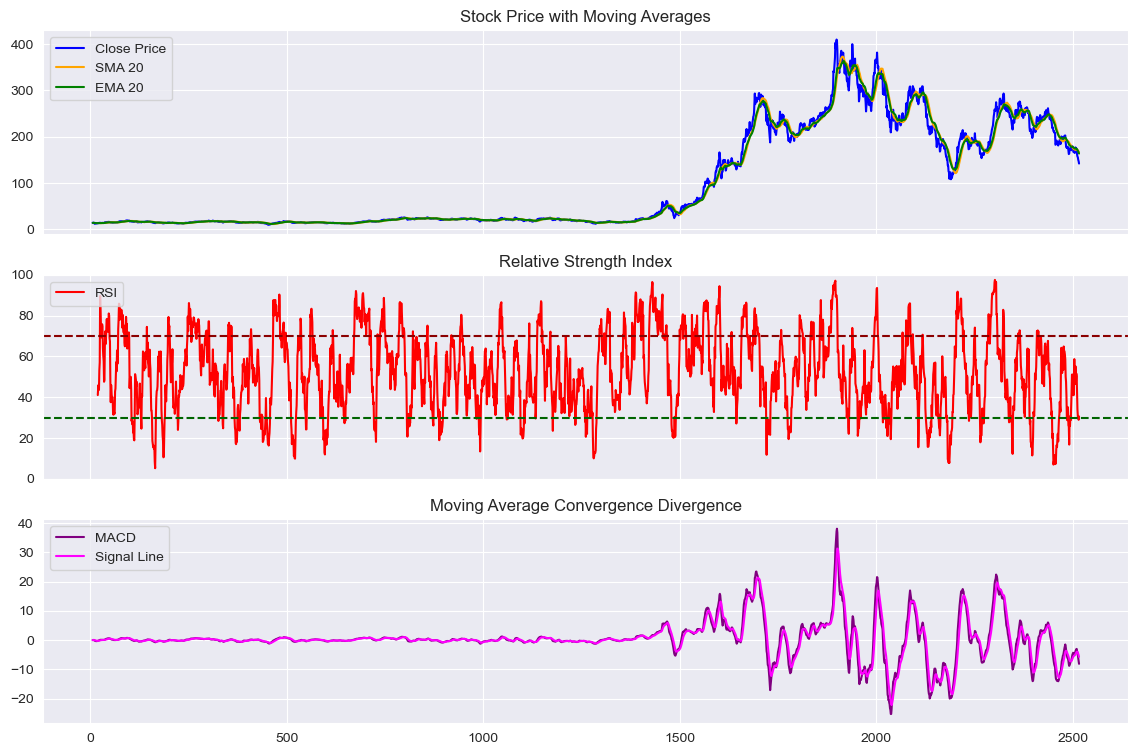

In [87]:
prediction.plot_indicators()

In [88]:
prediction.predict()

True

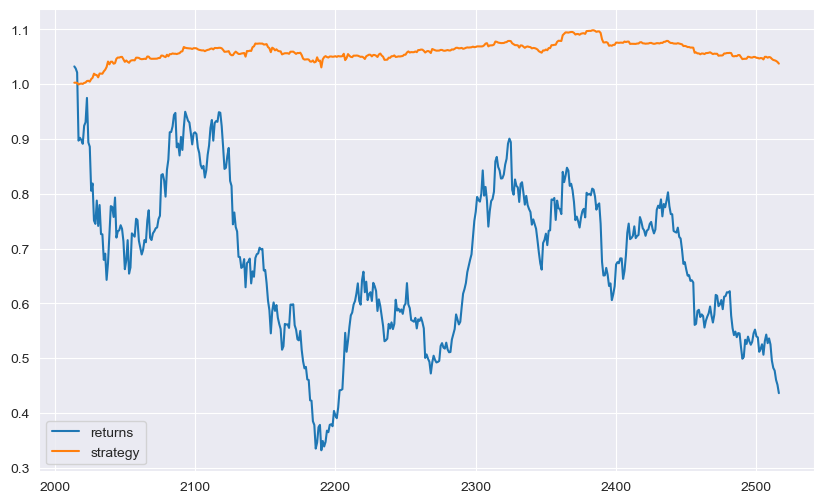

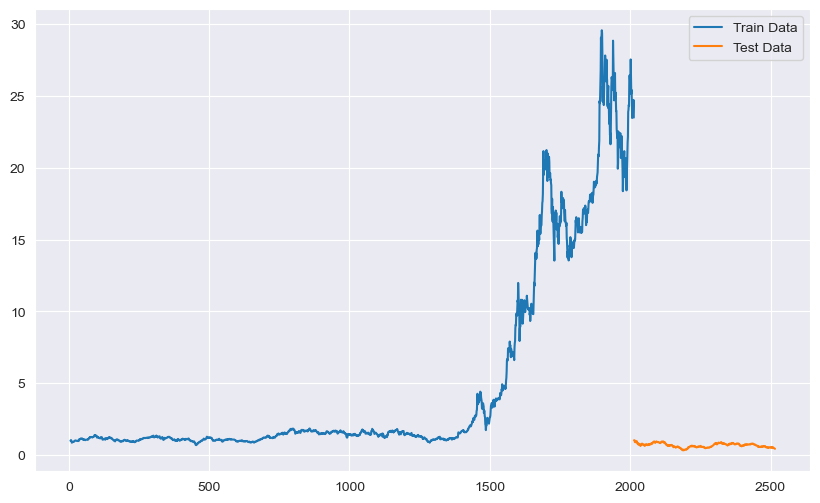

In [89]:
prediction.evaluate()

In [90]:
# np.exp(Test[['returns', 'strategy_returns']].sum())

In [91]:
# np.exp(Test[['returns', 'strategy_returns']].cumsum()).plot()